In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import math
import gym
import matplotlib.pyplot as plt
from acrobot import AcrobotEnv
import numpy as np
from tqdm import tqdm, trange

Heavily referencing this link
https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html

In [9]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(6, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 3)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x        


In [10]:
from collections import namedtuple
import random

Transition = namedtuple("Transition", ("state", "action", "next_state", "reward"))

class ReplayMemory():
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)

In [11]:
steps_done = 0
def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1.*steps_done/EPS_DECAY)
    if sample > eps_threshold:
        with torch.no_grad():
            return net(state).argmax()
    else:
        return torch.tensor(random.randrange(3))

In [12]:
def to_tensor(env_state):
    return torch.from_numpy(env_state).float()

In [14]:
BATCH_SIZE = 64
GAMMA = 0.999
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200
num_episodes = 50

In [17]:
env = AcrobotEnv()

# Initialize replay memory
memory  = ReplayMemory(10000)

# Initialize action-value function Q
net = Net()

# initialize target action-value function Q'
clone = Net()
clone.load_state_dict(net.state_dict())
clone.eval()

optimizer = optim.RMSprop(net.parameters())

# For each episode
for i in range(num_episodes):
    state = env.reset()
    for j in tqdm(range(100)):
        # Select action according to epsilon greedy 
        action = select_action(to_tensor(state))
        
        # execution action and observe reward and next_state
        next_state, reward, done, _ = env.step(action.item())
        reward = torch.tensor(reward)
        
        # store transition in memory
        memory.push(to_tensor(state), action, to_tensor(state), reward)

        state = next_state
        if len(memory) >= BATCH_SIZE:
            # sample random minibatch of transitions
            minibatch = memory.sample(BATCH_SIZE)
            batch = Transition(*zip(*minibatch))
            state_batch = torch.stack(batch.state)
            action_batch = torch.stack(batch.action).view((64,1))
            reward_batch = torch.stack(batch.reward)

            # compute state values
            state_action_values = net(state_batch).gather(1, action_batch)

            # compute y_j
            next_state_values = clone(state_batch).max(1)[0]
            y_j = reward_batch.float() + GAMMA*next_state_values

            criterion = nn.MSELoss()
            loss = criterion(state_action_values, y_j)
            optimizer.zero_grad()
            loss.backward()
            # clip error term between -1 and 1 
            for param in net.parameters():
                param.grad.data.clamp_(-1, 1)
            optimizer.step()
        if done:
            break
    clone.load_state_dict(net.state_dict())


  0%|          | 0/100 [00:00<?, ?it/s]

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: Could not seed environment <AcrobotEnv instance>


100%|██████████| 100/100 [00:00<00:00, 364.50it/s]


100%|██████████| 10000/10000 [00:02<00:00, 4251.20it/s]


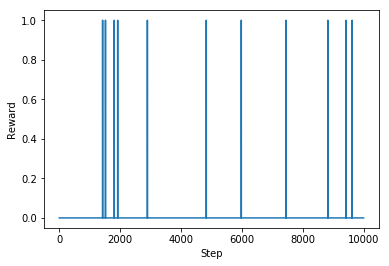

In [21]:

state = env.reset()
rewards = []
for i in tqdm(range(10000)):
    action = select_action(to_tensor(state))
    state, reward, done, _ = env.step(action.item())
    rewards.append(reward)

plt.figure()
plt.xlabel("Step")
plt.ylabel("Reward")
plt.plot(rewards)
plt.show()  

In [28]:
import time
for i in trange(10, desc='1st loop'):
    for j in trange(5, desc='2nd loop', leave=False):
        for k in trange(100, desc='3nd loop'):
            time.sleep(0.1)

2nd loop:   0%|          | 0/5 [00:00<?, ?it/s]

3nd loop:   0%|          | 0/100 [00:00<?, ?it/s]

3nd loop:   1%|          | 1/100 [00:00<00:10,  9.51it/s]

3nd loop:   2%|▏         | 2/100 [00:00<00:10,  9.45it/s]

3nd loop:   3%|▎         | 3/100 [00:00<00:10,  9.37it/s]

3nd loop:   4%|▍         | 4/100 [00:00<00:10,  9.36it/s]

3nd loop:   5%|▌         | 5/100 [00:00<00:10,  9.30it/s]

3nd loop:   6%|▌         | 6/100 [00:00<00:10,  9.22it/s]

3nd loop:   7%|▋         | 7/100 [00:00<00:10,  9.21it/s]

3nd loop:   8%|▊         | 8/100 [00:00<00:09,  9.32it/s]

3nd loop:   9%|▉         | 9/100 [00:00<00:09,  9.40it/s]

3nd loop:  10%|█         | 10/100 [00:01<00:09,  9.46it/s]

3nd loop:  11%|█         | 11/100 [00:01<00:09,  9.48it/s]

3nd loop:  12%|█▏        | 12/100 [00:01<00:09,  9.40it/s]

3nd loop:  13%|█▎        | 13/100 [00:01<00:09,  9.45it/s]

3nd loop:  14%|█▍        | 14/100 [00:01<00:09,  9.40it/s]

3nd loop:  15%|█▌        | 15/100 [00:01<00:09,  9.37it/s]

3nd loop:

KeyboardInterrupt: 